<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/IMDB_WIKI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

In [61]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 271 (delta 75), reused 18 (delta 8), pack-reused 142 (from 1)
Receiving objects: 100% (271/271), 9.51 MiB | 11.59 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/DLVR


In [62]:
from utils.imdb_wiki import download_and_extract, create_dataframe
extract_dir = "/content/extracted"
download_and_extract(extract_dir)
df = create_dataframe(extract_dir)

UnboundLocalError: local variable 'url' referenced before assignment

In [ ]:
import os
import tarfile
import urllib.request
from scipy.io import loadmat

# Function to download and extract tar files
def download_and_extract(url, extract_dir):
    # File name based on URL
    file_name = url.split('/')[-1]
    file_path = os.path.join(extract_dir, file_name)

    # Download the file
    print(f"Downloading {file_name}...")
    urllib.request.urlretrieve(url, file_path)
    print(f"Downloaded {file_name}.")

    # Extract the tar file
    print(f"Extracting {file_name}...")
    with tarfile.open(file_path, "r") as tar:
        tar.extractall(extract_dir)
    print(f"Extracted {file_name}.")

    # Remove the tar file after extraction to save space
    os.remove(file_path)
    print(f"Removed {file_name}.")

# Define URLs and destination path
urls = [
    "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar",
    "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar"
]

extract_dir = "/content/extracted"

# Create the destination directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download and extract each dataset
for url in urls:
    download_and_extract(url, extract_dir)

print("All datasets downloaded and extracted.")

Downloaded wiki_crop.tar.
Extracting wiki_crop.tar...
Extracted wiki_crop.tar.
Removed wiki_crop.tar.
Downloaded imdb_crop.tar.
Extracting imdb_crop.tar...
Extracted imdb_crop.tar.
Removed imdb_crop.tar.
All datasets downloaded and extracted.


In [ ]:
# Locate the .mat file and load it
mat_file_path = os.path.join(extract_dir, 'imdb/imdb.mat')
data = loadmat(mat_file_path)
metadata = data['imdb'][0, 0]

import datetime
import numpy as np

def matlab_datenum_to_year(matlab_datenum):
    """Convert MATLAB datenum to year, with error handling for extreme values."""
    try:
        python_base_date = datetime.datetime(1, 1, 1)
        days_offset = int(matlab_datenum) - 366  # Convert to integer
        converted_date = python_base_date + datetime.timedelta(days=days_offset)
        return converted_date.year
    except OverflowError:
        # print(f"OverflowError: Unable to convert MATLAB datenum {matlab_datenum}.")
        return None

dob = metadata['dob'][0]
dob_years = [matlab_datenum_to_year(date[0] if isinstance(date, np.ndarray) else date) for date in dob]
photo_taken = metadata['photo_taken'][0]
full_paths = metadata['full_path'][0]
gender = metadata['gender'][0]
face_score = metadata['face_score'][0]
second_face_score = metadata['second_face_score'][0]

# Ensure dob_years has np.nan for invalid entries
dob_years = np.array([year if year is not None else np.nan for year in dob_years], dtype=float)

# Calculate age while keeping alignment
ages = np.array([photo - dob if dob is not None else np.nan for dob, photo in zip(dob_years, photo_taken)])

# Filter valid indices based on face_score, second_face_score, and valid dob_years
valid_indices = np.where((face_score > 1.0) & (np.isnan(second_face_score)) & (~np.isnan(dob_years)))[0]

# Apply the filter to the arrays
filtered_paths = full_paths[valid_indices]
filtered_ages = ages[valid_indices]
filtered_gender = gender[valid_indices]
filtered_dob = dob_years[valid_indices]
filtered_photo_taken = photo_taken[valid_indices]

# Convert paths to strings and create a full path for each image
base_image_path = "/content/datasets/imdb_crop/"
image_paths = [os.path.join(base_image_path, path[0]) for path in filtered_paths]

# Set minimum dimensions for ResNet input and initialize filtered lists
min_width, min_height = 224, 224
valid_image_paths = []
valid_ages = []
valid_gender = []
valid_dob = []
valid_photo_taken = []

# Check each image for dimensions and RGB mode
from PIL import Image
for i, path in enumerate(image_paths):
    try:
        with Image.open(path) as img:
            # Check if image meets the minimum size and has RGB channels
            if img.width >= min_width and img.height >= min_height and img.mode == 'RGB':
                valid_image_paths.append(path)
                valid_ages.append(filtered_ages[i])
                valid_gender.append(filtered_gender[i])
                valid_dob.append(filtered_dob[i])
                valid_photo_taken.append(filtered_photo_taken[i])
    except Exception as e:
        print(f"Error opening image {path}: {e}")
        continue  # Skip image if there's an error

# Create final DataFrame with filtered images and metadata
import pandas as pd
df = pd.DataFrame({
    "image_path": valid_image_paths,
    "age": valid_ages,
    "gender": valid_gender,
    "dob": valid_dob,
    "photo_taken": valid_photo_taken
})

# Display the first 10 rows of the DataFrame
df.head(10).style.set_properties(**{'text-align': 'center'})

,image_path,age,gender,dob,photo_taken
0,/content/datasets/imdb_crop/01/nm0000001_rm946909184_1899-5-10_1968.jpg,69.000000,1.000000,1899.000000,1968
1,/content/datasets/imdb_crop/01/nm0000001_rm980463616_1899-5-10_1968.jpg,69.000000,1.000000,1899.000000,1968
2,/content/datasets/imdb_crop/02/nm0000002_rm1363385088_1924-9-16_2004.jpg,80.000000,0.000000,1924.000000,2004
3,/content/datasets/imdb_crop/02/nm0000002_rm2585828096_1924-9-16_2006.jpg,82.000000,0.000000,1924.000000,2006
4,/content/datasets/imdb_crop/02/nm0000002_rm370988544_1924-9-16_1991.jpg,67.000000,0.000000,1924.000000,1991
5,/content/datasets/imdb_crop/02/nm0000002_rm4111175424_1924-9-16_2010.jpg,86.000000,0.000000,1924.000000,2010
6,/content/datasets/imdb_crop/02/nm0000002_rm4213815808_1924-9-16_1990.jpg,66.000000,0.000000,1924.000000,1990
7,/content/datasets/imdb_crop/02/nm0000002_rm505206272_1924-9-16_1991.jpg,67.000000,0.000000,1924.000000,1991
8,/content/datasets/imdb_crop/02/nm0000002_rm800626688_1924-9-16_2006.jpg,82.000000,0.000000,1924.000000,2006
9,/content/datasets/imdb_crop/02/nm0000002_rm81958912_1924-9-16_2005.jpg,81.000000,0.000000,1924.000000,2005


Age: 69.0


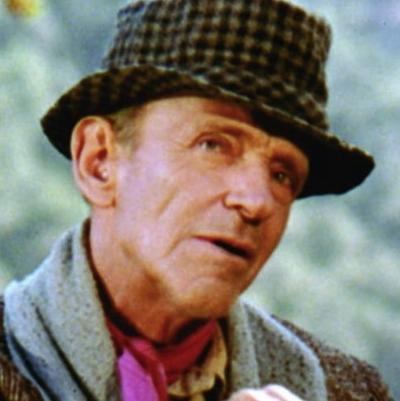

Age: 69.0


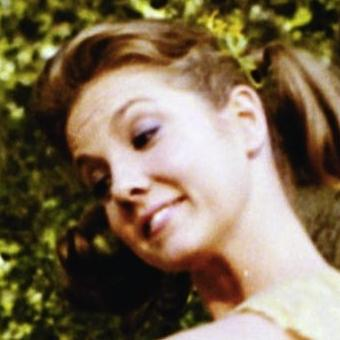

Age: 80.0


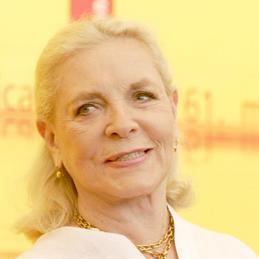

Age: 82.0


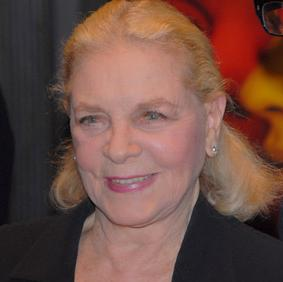

Age: 67.0


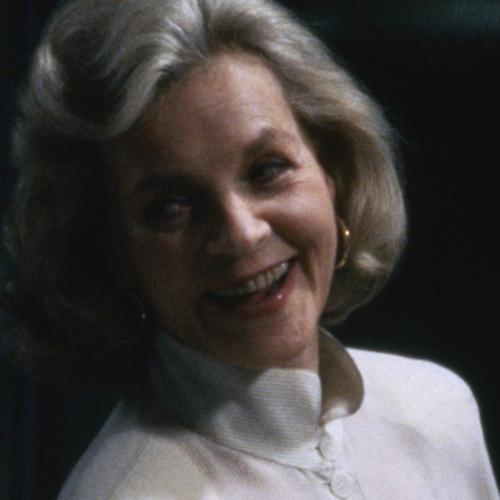

Age: 86.0


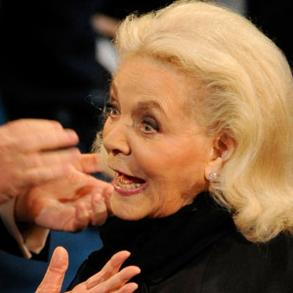

Age: 66.0


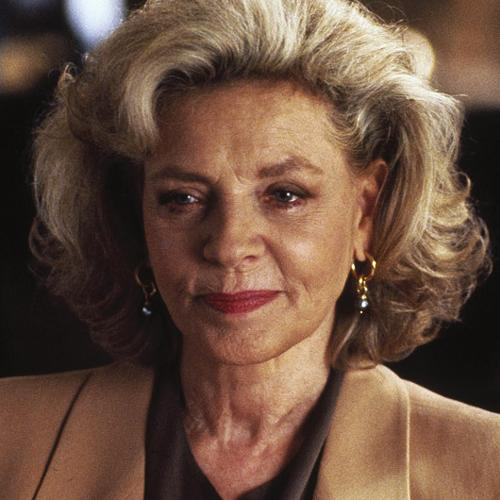

Age: 67.0


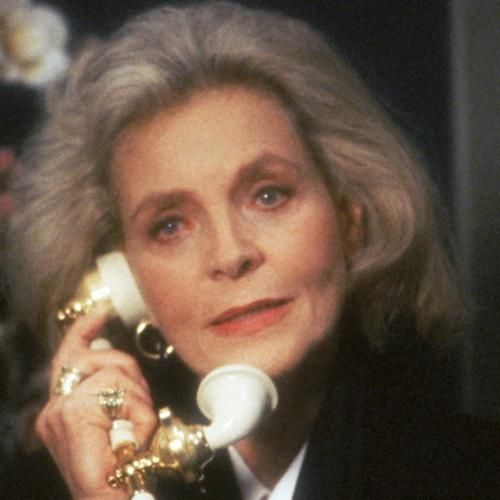

Age: 82.0


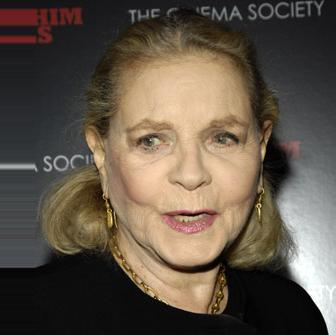

Age: 81.0


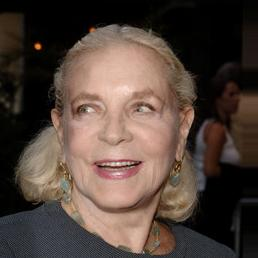

Age: 67.0


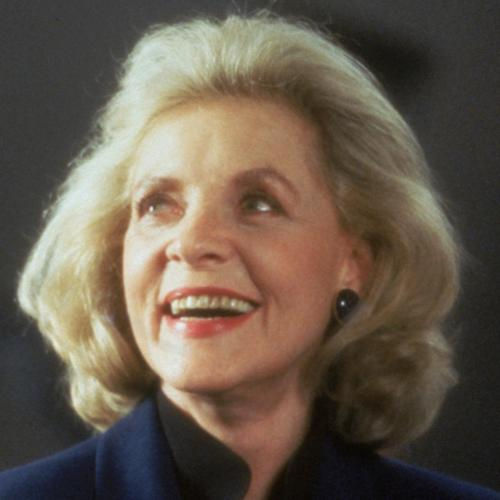

Age: 29.0


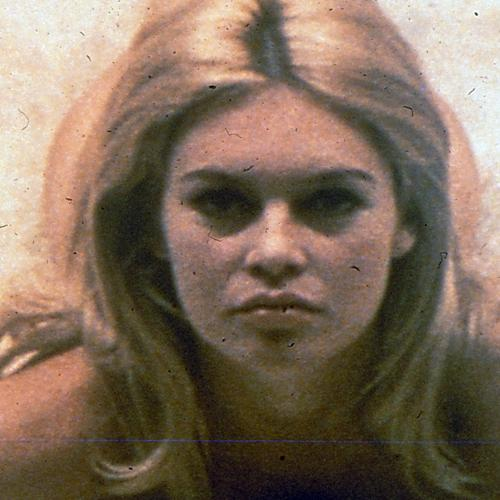

Age: 29.0


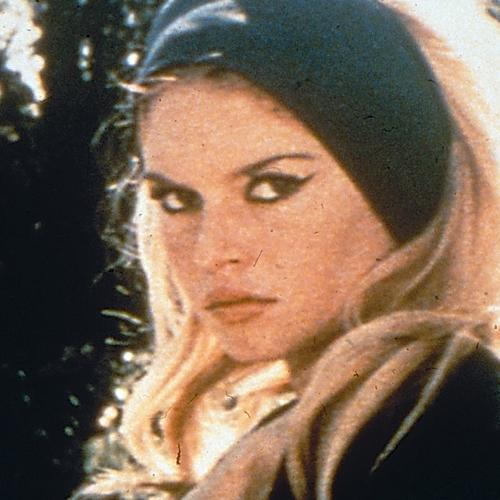

Age: 29.0


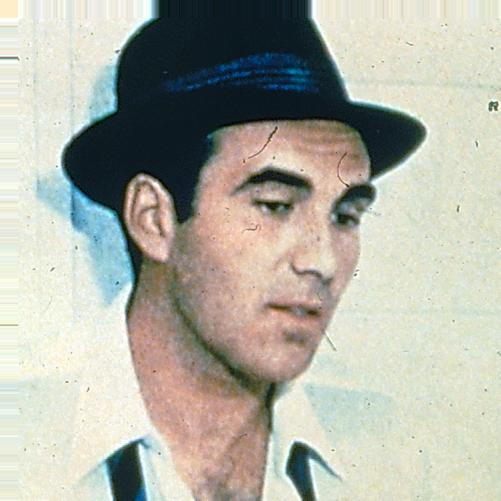

Age: 29.0


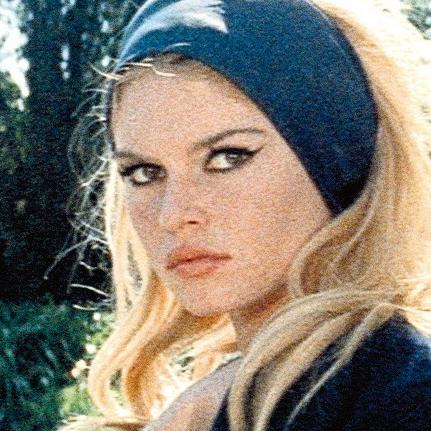

Age: 31.0


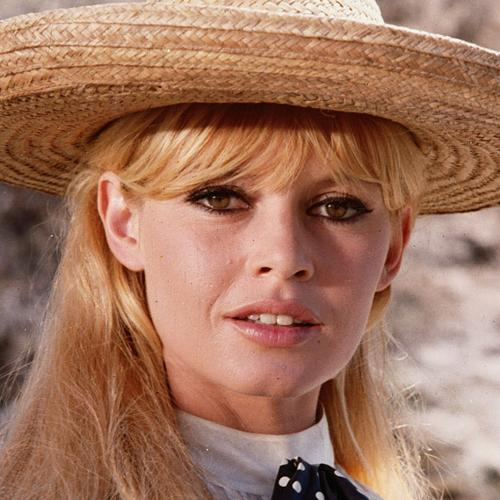

Age: 29.0


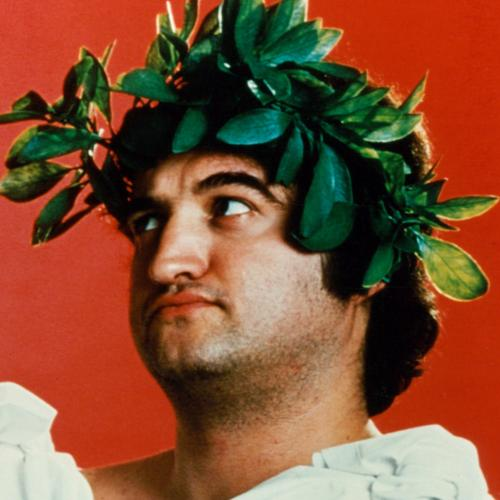

Age: 29.0


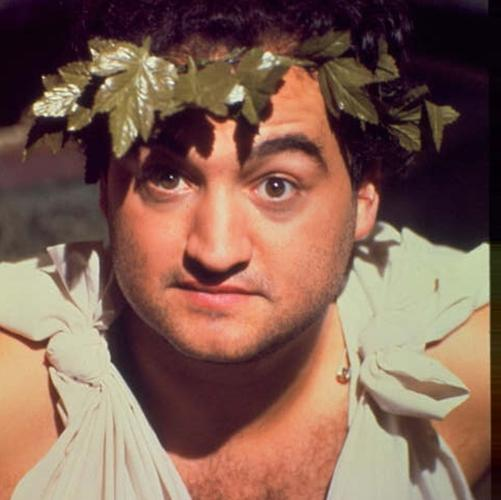

Age: 29.0


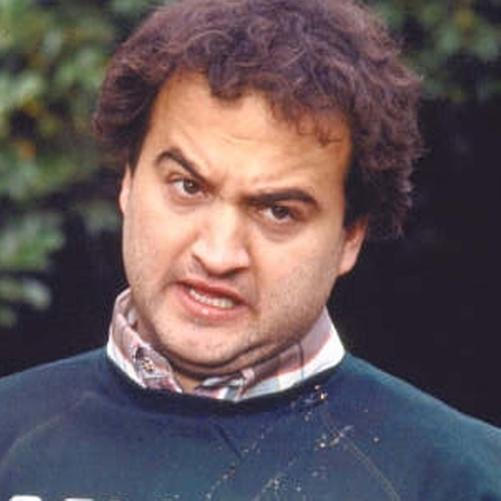

Age: 85.0


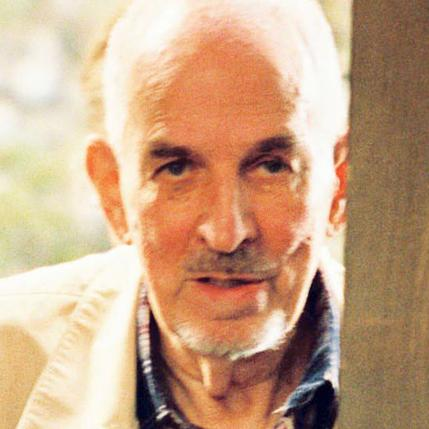

In [ ]:
# Display an image based on image_path and print age
from IPython.display import Image
for _, row in df.head(20).iterrows():
    image_path = row['image_path']
    age = row['age']
    print(f"Age: {age}")
    display(Image(filename=image_path))